In [83]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from final_dataloader import ImageDataset
import final_model as AENet

import argparse
import numpy as np
import sys
import os
import imageio

In [84]:
options = argparse.ArgumentParser()

options.add_argument('--save-dir', action="store", dest="save_dir", default="my_save_dir")
options.add_argument('-pt', action="store", dest="pretrained_file", default=None)
options.add_argument('-bs', action="store", dest="batch_size", default = 128, type = int)
options.add_argument('-ds', action="store", dest="datadir", default = "data_folder/my_data//")

options.add_argument('-iter', action="store", dest="max_iter", default = 5, type = int) #800
options.add_argument('-lr', action="store", dest="lr", default=1e-3, type = float)
options.add_argument('-nz', action="store", dest="nz", default=2, type = int)
options.add_argument('-lamb', action="store", dest="lamb", default=0.0000001, type = float)
options.add_argument('-lamb2', action="store", dest="lamb2", default=0.001, type = float)
options.add_argument('--conditional', action="store_true")

args, unknown = options.parse_known_args()
os.makedirs(args.save_dir, exist_ok=True)
with open(os.path.join(args.save_dir, "log.txt"), 'w') as f:
    print(args, file=f)



In [85]:
# retrieve dataloader
trainset = ImageDataset(datadir=args.datadir, mode='train')
testset = ImageDataset(datadir=args.datadir, mode='test')

train_loader = DataLoader(trainset, batch_size=args.batch_size, drop_last=False, shuffle=True)
test_loader = DataLoader(testset, batch_size=args.batch_size, drop_last=False, shuffle=False)

print('Data loaded')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

Data loaded


In [86]:
#VAE 
model = AENet.VAE(latent_variable_size=args.nz, batchnorm=True)

if args.pretrained_file is not None:
    model.load_state_dict(torch.load(args.pretrained_file))
    print("Pre-trained model loaded")
    sys.stdout.flush()

In [87]:
#cross_entropy
CE_weights = torch.FloatTensor([4.5, 0.5])
 
if torch.cuda.is_available():
    print('Using GPU')
    model.cuda()
    CE_weights = CE_weights.cuda()

CE = nn.CrossEntropyLoss(CE_weights)


In [88]:
optimizer = optim.Adam([{'params': model.parameters()}], lr = args.lr)

In [89]:
def loss_function(recon_x, x, mu, logvar, latents):
    MSE = nn.MSELoss()
    lloss = MSE(recon_x,x)

    if args.lamb>0:
        KL_loss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        lloss = lloss + args.lamb*KL_loss

    return lloss

In [90]:
def train(epoch):
    model.train()

    train_loss = 0
    total_clf_loss = 0

    for batch_idx, samples in enumerate(train_loader):
 
        inputs = Variable(samples['image_tensor'])
        if torch.cuda.is_available():
            inputs = inputs.cuda()
 
        optimizer.zero_grad()
        recon_inputs, latents, mu, logvar = model(inputs)
        loss = loss_function(recon_inputs, inputs, mu, logvar, latents)
        train_loss += loss.data.item() * inputs.size(0)

        loss.backward()
        optimizer.step()

    with open(os.path.join(args.save_dir, "log.txt"), 'a') as f:
        print('Epoch: {} Average loss: {:.15f} Clf loss: {:.15f} '.format(epoch, train_loss / len(train_loader.dataset), total_clf_loss / len(train_loader.dataset)), file=f)

In [91]:
def test(epoch):
    model.eval()
    if args.conditional:
        netCondClf.eval()

    test_loss = 0
    total_clf_loss = 0

    for i, samples in enumerate(test_loader):
 
        inputs = Variable(samples['image_tensor'])
        if torch.cuda.is_available():
            inputs = inputs.cuda()
 
        recon_inputs, latents, mu, logvar = model(inputs)
        
        loss = loss_function(recon_inputs, inputs, mu, logvar, latents)
        test_loss += loss.data.item() * inputs.size(0)
        
        if args.conditional:
            targets = Variable(samples['binary_label'])
            if torch.cuda.is_available():
                targets = targets.cuda()
            clf_outputs = netCondClf(latents)
            class_clf_loss = CE(clf_outputs, targets.view(-1).long())
            total_clf_loss += class_clf_loss.data.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    total_clf_loss /= len(test_loader.dataset)

    with open(os.path.join(args.save_dir, "log.txt"), 'a') as f:
        print('Test set loss: {:.15f} Test clf loss: {:.15f}'.format(test_loss, total_clf_loss), file=f)
    
    return test_loss

In [92]:
def save(epoch):
    model_dir = os.path.join(args.save_dir, "models")
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.cpu().state_dict(), os.path.join(model_dir, str(epoch)+".pth"))
    if torch.cuda.is_available():
        model.cuda()

In [93]:
def generate_image(epoch):
    img_dir = os.path.join(args.save_dir, "images")
    os.makedirs(img_dir, exist_ok=True)
    model.eval()

    for i in range(5):
        samples = train_loader.dataset[np.random.randint(30)]
        inputs = samples['image_tensor']
        inputs = Variable(inputs.view(1,1,64,64))
 
        if torch.cuda.is_available():
            inputs = inputs.cuda()
 
        recon_inputs, _, _, _ = model(inputs)
 
        imageio.imwrite(os.path.join(img_dir, "Train_epoch_%s_inputs_%s.jpg" % (epoch, i)), np.uint8(inputs.cpu().data.view(64,64).numpy()*255))
        imageio.imwrite(os.path.join(img_dir, "Train_epoch_%s_recon_%s.jpg" % (epoch, i)), np.uint8(recon_inputs.cpu().data.view(64,64).numpy()*255))
 
        samples = test_loader.dataset[np.random.randint(5)]
        inputs = samples['image_tensor']
        inputs = Variable(inputs.view(1,1,64,64))
 
        if torch.cuda.is_available():
            inputs = inputs.cuda()
 
        recon_inputs, _, _, _ = model(inputs)
 
        imageio.imwrite(os.path.join(img_dir, "Test_epoch_%s_inputs_%s.jpg" % (epoch, i)), np.uint8(inputs.cpu().data.view(64,64).numpy()*255))
        imageio.imwrite(os.path.join(img_dir, "Test_epoch_%s_recon_%s.jpg" % (epoch, i)), np.uint8(recon_inputs.cpu().data.view(64,64).numpy()*255))

In [94]:
# main training loop
generate_image(0)
save(0)
 
_ = test(0)

for epoch in range(args.max_iter):
    print(epoch)
    train(epoch)
    _ = test(epoch)
 
    if epoch % 10 == 1:
        generate_image(epoch)
        save(epoch)

0
1
2
3
4


In [113]:
# visualise latent space
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors

def plot_latent_space_with_labels(data_loader, model):
    for i, dict in enumerate(data_loader):
        labels = dict["label"]
    
    d = {i:[] for i in labels}
    print(d)

    with torch.no_grad():
        for i, dict in enumerate(data_loader):
            
            images = dict["image_tensor"]
            labels = dict["label"]
            
            embedding = model.get_latent_var(images)
            print(labels)
            print(embedding)

            for i, name in zip(range(len(labels)), labels):
                
                d[name].append(embedding[i].to('cpu').numpy())
    
    print(d)
    colors = list(mcolors.CSS4_COLORS.items())*10
    for i,j in zip(labels, range(len(labels))):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][0], d[i][1],
            color=colors[j][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

{'1_73_18': [], '2_50_53': [], '8_55_54': [], '8_86_13': [], '2_70_68': [], '3_73_36': [], '3_71_58': [], '8_86_37': [], '9_84_92': [], '9_3_58': [], '6_15_8': [], '9_82_29': [], '0_28_6': [], '1_57_90': [], '6_90_14': [], '9_43_12': [], '5_6_81': [], '1_1_18': [], '8_15_72': [], '1_30_63': [], '6_18_21': [], '6_0_6': [], '7_68_21': [], '2_47_93': [], '5_84_3': [], '9_58_22': [], '5_90_91': [], '6_74_24': [], '1_53_71': [], '1_70_69': [], '0_35_29': [], '3_42_36': [], '7_16_87': [], '4_43_29': [], '6_10_76': [], '9_45_76': [], '3_16_61': [], '8_2_87': [], '9_7_4': [], '3_56_57': [], '9_42_5': [], '0_25_53': [], '3_72_52': [], '1_22_84': [], '9_19_18': [], '7_8_62': [], '9_23_17': [], '2_76_86': [], '0_36_89': [], '1_30_9': [], '8_38_88': [], '6_16_75': [], '8_31_75': [], '1_43_67': [], '8_46_17': [], '3_40_63': [], '5_23_9': [], '6_92_18': [], '7_47_69': [], '9_48_13': [], '1_59_43': [], '1_44_4': [], '9_68_6': [], '1_7_65': [], '4_90_48': [], '9_74_73': [], '9_92_57': [], '5_89_83': [

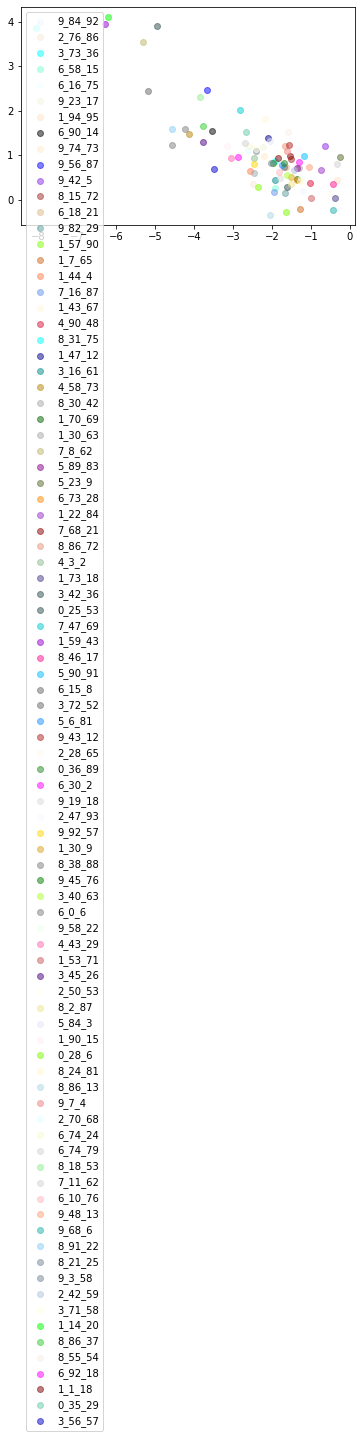

In [114]:
plot_latent_space_with_labels(
    data_loader=train_loader,
    model=model)

plt.legend()
plt.show()

In [ ]:
for i, dict in enumerate(train_loader): 
    NUM_CLASSES = len(dict["label"])

In [32]:
for i, dict in enumerate(train_loader):
    print(dict)

{'image_tensor': tensor([[[[4.3534e-03, 3.3690e-03, 5.7406e-03,  ..., 1.0063e-02,
           8.4846e-03, 7.5032e-03],
          [4.6519e-03, 2.6266e-03, 4.5369e-03,  ..., 9.0817e-03,
           7.7647e-03, 5.9168e-03],
          [4.9996e-03, 2.5681e-03, 3.5317e-03,  ..., 8.5873e-03,
           8.4928e-03, 6.2345e-03],
          ...,
          [4.8692e-03, 3.3300e-03, 2.2977e-03,  ..., 7.3600e-03,
           7.7458e-03, 8.9263e-03],
          [4.6434e-03, 3.7550e-03, 2.8193e-03,  ..., 2.9771e-03,
           4.6767e-03, 5.2508e-03],
          [5.0274e-03, 3.9836e-03, 1.7481e-03,  ..., 1.5745e-03,
           3.0085e-03, 3.0321e-03]]],


        [[[8.3627e-03, 8.3636e-03, 5.1829e-03,  ..., 2.5218e-03,
           3.7512e-03, 5.4607e-03],
          [8.0045e-03, 1.1519e-02, 9.7679e-03,  ..., 6.1145e-05,
           2.1654e-03, 3.5929e-03],
          [5.4606e-03, 1.0436e-02, 1.1552e-02,  ..., 3.8609e-03,
           5.8214e-03, 5.1873e-03],
          ...,
          [1.3949e-03, 2.8754e-03, 5.986